In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report

tf.random.set_seed(42)

2025-09-01 19:35:14.134589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756755314.499789      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756755314.599768      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(384, 512, 3)


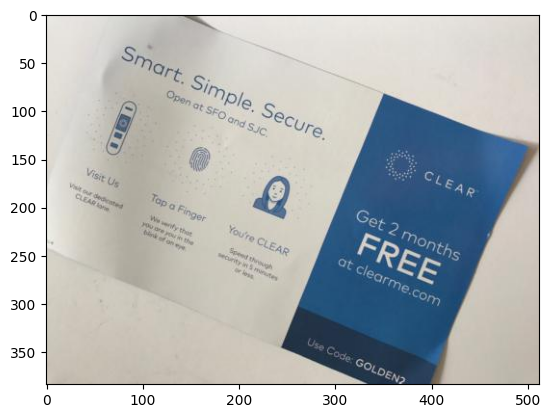

In [3]:
path = '/kaggle/input/waste-segregation-image-dataset/Dataset/train/biodegradable/paper_waste'
img = os.listdir(path)
img1 = mpimg.imread(path + '/' + img[200])
plt.imshow(img1)
print(img1.shape)

In [4]:
# setting base path and image size
dataset_path = '/kaggle/input/waste-segregation-image-dataset/Dataset'
img_size = (224,224)

# class labels mapping
labels = {
    "biodegradable":0,
    "non_biodegradable":1
}

# function to load images and labels
def load_images(dataset_path,type):
  X_majority = []
  X_minority = []
  y_majority = []
  y_minority = []

  if type in os.listdir(dataset_path):
    data = os.path.join(dataset_path, type)

    for category in os.listdir(data):
      category_path = os.path.join(data, category)
      if os.path.isdir(category_path):
        label = labels[category]

        for subfolder in os.listdir(category_path):
          subfolder_path = os.path.join(category_path, subfolder)
          count=0
          for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)
            count+=1
            if count>1000:
              break
            try:
              img = Image.open(img_path).convert("RGB")
              img = img.resize(img_size)  
              if label==0:
                y_majority.append(label)
                X_majority.append(img)
              else:
                y_minority.append(label)
                X_minority.append(img)
            except Exception as e:
              print(f"Error loading {img_path}: {e}")
  else:
    print(f"Not a valid path or type, check once again!")

  return np.array(y_majority), np.array(y_minority), np.array(X_majority), np.array(X_minority)

In [5]:
y_majority, y_minority, X_majority, X_minority = load_images(dataset_path,"train")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Error loading /kaggle/input/waste-segregation-image-dataset/Dataset/train/non_biodegradable/ewaste/00000006.jpg: image file is truncated (4 bytes not processed)


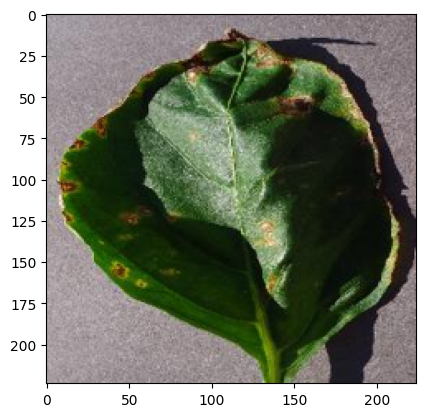

In [6]:
plt.imshow(X_majority[0])

In [7]:
print(X_majority.shape)
print(X_minority.shape)
print(y_majority.shape)
print(y_minority.shape)

(3453, 224, 224, 3)
(1466, 224, 224, 3)
(3453,)
(1466,)


In [8]:
# Data Augmentation
datagen = ImageDataGenerator(
  rotation_range=20,
  zoom_range=0.15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=True,
  fill_mode='nearest'
)

# Number of synthetic images to generate
no_to_generate = 1700

# Generate augmented images
augmented_images = []
augmented_labels = []

# Flow images through generator and collect
batch_size = 32
generated = 0


for images, labels in datagen.flow(X_minority, y_minority, batch_size=batch_size, shuffle=True):
    for img, label in zip(images, labels):
        augmented_images.append(img)
        augmented_labels.append(label)
        generated += 1
        if generated >= no_to_generate:
            break
    if generated >= no_to_generate:
        break


augmented_images = np.array(augmented_images, dtype=np.uint8)
augmented_labels = np.array(augmented_labels)


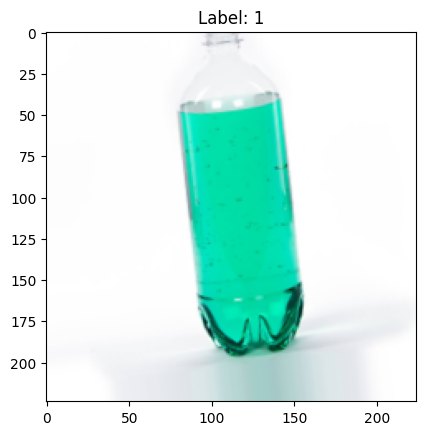

In [9]:
import matplotlib.pyplot as plt

plt.imshow(augmented_images[5])  # checking one image
plt.title(f"Label: {augmented_labels[0]}")
plt.show()


In [10]:
print(f"\nAfter augmentation:")
print(f"Total samples: {len(augmented_images)}")
print(f"Class 0 count: {np.sum(augmented_labels == 0)}")
print(f"Class 1 count: {np.sum(augmented_labels == 1)}")


After augmentation:
Total samples: 1700
Class 0 count: 0
Class 1 count: 1700


In [11]:
# Combining real + augmented data
X_balanced = np.concatenate((X_majority, X_minority, augmented_images), axis=0)
y_balanced = np.concatenate((y_majority, y_minority, augmented_labels), axis=0)


In [12]:
print(f"\nAfter combining augmentation:")
print(f"Total samples: {len(X_balanced)}")
print(f"Class 0 count: {np.sum(y_balanced == 0)}")
print(f"Class 1 count: {np.sum(y_balanced == 1)}")


After combining augmentation:
Total samples: 6619
Class 0 count: 3453
Class 1 count: 3166


In [13]:
# Normalization
X_preprocessed = X_balanced / 255

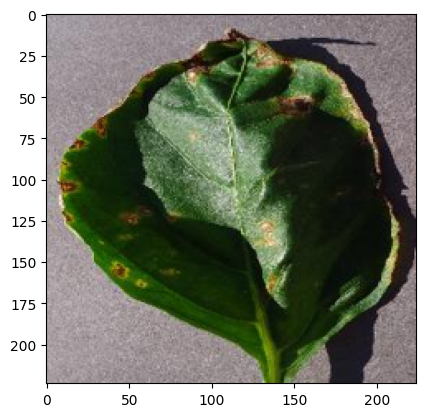

In [14]:
plt.imshow(X_balanced[0])

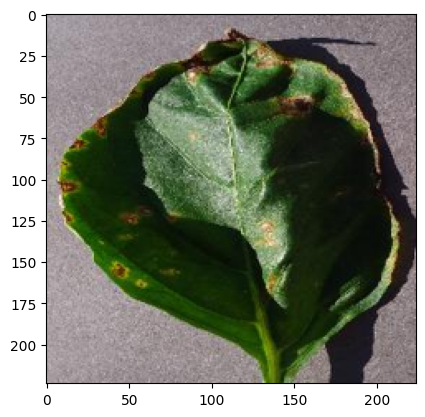

In [15]:
plt.imshow(X_preprocessed[0])

In [16]:
# Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

In [17]:
del X_preprocessed
del X_balanced
del augmented_images
del augmented_labels
del X_majority
del X_minority
del y_majority
del y_minority

In [18]:
convolutional_base = ResNet50(weights = 'imagenet', include_top=False, input_shape=(224,224,3))

I0000 00:00:1756755426.342712      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756755426.343364      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
convolutional_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [20]:
x = convolutional_base.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=convolutional_base.input, outputs=output)

In [21]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 2


In [22]:
model.compile(optimizer = optimizers.RMSprop(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [23]:
history = model.fit(X_train, y_train, batch_size=16, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10


I0000 00:00:1756755472.525269      67 service.cc:148] XLA service 0x795a5c003fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756755472.526641      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756755472.526672      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756755476.017882      67 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756755494.344057      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


331/331 ━━━━━━━━━━━━━━━━━━━━ 135s 241ms/step - acc: 0.6412 - loss: 0.6980 - val_acc: 0.4766 - val_loss: 1.1494
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 54s 163ms/step - acc: 0.8319 - loss: 0.3867 - val_acc: 0.6662 - val_loss: 0.5818
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 54s 162ms/step - acc: 0.8847 - loss: 0.2886 - val_acc: 0.9403 - val_loss: 0.1738
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 54s 163ms/step - acc: 0.9276 - loss: 0.2033 - val_acc: 0.9728 - val_loss: 0.1096
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 54s 163ms/step - acc: 0.9532 - loss: 0.1555 - val_acc: 0.9736 - val_loss: 0.0970
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 55s 165ms/step - acc: 0.9670 - loss: 0.1212 - val_acc: 0.9751 - val_loss: 0.0840
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 55s 165ms/step - acc: 0.9793 - loss: 0.0888 - val_acc: 0.9713 - val_loss: 0.0991
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 55s 165ms/step - acc: 0.9820 - loss: 0.0819 - val_acc: 0.9781 - val_loss: 0.0815
Epoch 9/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 55

In [24]:
# Save full model
model.save("/kaggle/working/waste_classifier.keras")

In [25]:
# setting base path and image size
dataset_path = '/kaggle/input/waste-segregation-image-dataset/Dataset'
img_size = (224,224)

# class labels mapping
labels = {
    "biodegradable":0,
    "non_biodegradable":1
}

# function to load images and labels
def load_images(dataset_path,type):
  X_majority = []
  X_minority = []
  y_majority = []
  y_minority = []

  if type in os.listdir(dataset_path):
    data = os.path.join(dataset_path, type)

    for category in os.listdir(data):
      category_path = os.path.join(data, category)
      if os.path.isdir(category_path):
        label = labels[category]

        for subfolder in os.listdir(category_path):
          subfolder_path = os.path.join(category_path, subfolder)
          count=0
          for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)
            count+=1
            if count>1000:
              break
            try:
              img = Image.open(img_path).convert("RGB")
              img = img.resize(img_size) 
              if label==0:
                y_majority.append(label)
                X_majority.append(img)
              else:
                y_minority.append(label)
                X_minority.append(img)
            except Exception as e:
              print(f"Error loading {img_path}: {e}")
  else:
    print(f"Not a valid path or type, check once again!")

  return np.array(y_majority), np.array(y_minority), np.array(X_majority), np.array(X_minority)

In [26]:
y_majority2, y_minority2, X_majority2, X_minority2 = load_images(dataset_path, "val")

Error loading /kaggle/input/waste-segregation-image-dataset/Dataset/val/non_biodegradable/ewaste/00000261.jpg: image file is truncated (19 bytes not processed)


In [27]:
X_val = np.concatenate((X_majority2, X_minority2), axis=0)
y_val = np.concatenate((y_majority2, y_minority2), axis=0)
X_preprocessed2 = X_val / 255

In [28]:
loss, accuracy = model.evaluate(X_preprocessed2, y_val)
print(f'Test accuracy : {accuracy} and loss : {loss}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - acc: 0.9765 - loss: 0.0693
Test accuracy : 0.9583333134651184 and loss : 0.11355619132518768


In [29]:
X_val[0].shape

(224, 224, 3)

In [30]:
saved_model = load_model("/kaggle/working/waste_classifier.keras")
image_check = np.expand_dims(X_val[0], axis=0)
prediction = saved_model.predict(image_check,verbose=0)
prob = prediction[0][0]
if prob >= 0.5:
    print("Non-Biodegradable")
else:
    print("Biodegradable")

print(y_val[-1])

Non-Biodegradable
1


In [31]:
y_pred_prob = model.predict(X_preprocessed2)

y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

print(classification_report(y_val, y_pred, target_names=['Non-Biodegradable', 'Biodegradable']))

38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step
                   precision    recall  f1-score   support

Non-Biodegradable       0.98      0.96      0.97       894
    Biodegradable       0.90      0.94      0.92       306

         accuracy                           0.96      1200
        macro avg       0.94      0.95      0.95      1200
     weighted avg       0.96      0.96      0.96      1200



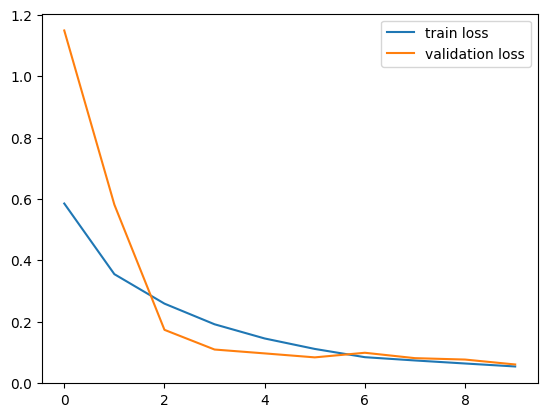

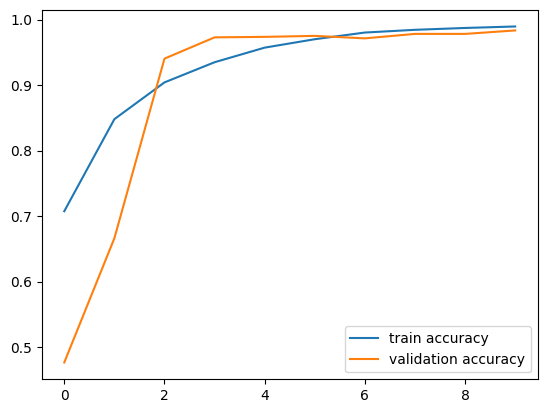

In [32]:
h = history

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# plot the accuracy value
plt.plot(h.history['acc'], label='train accuracy')
plt.plot(h.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step


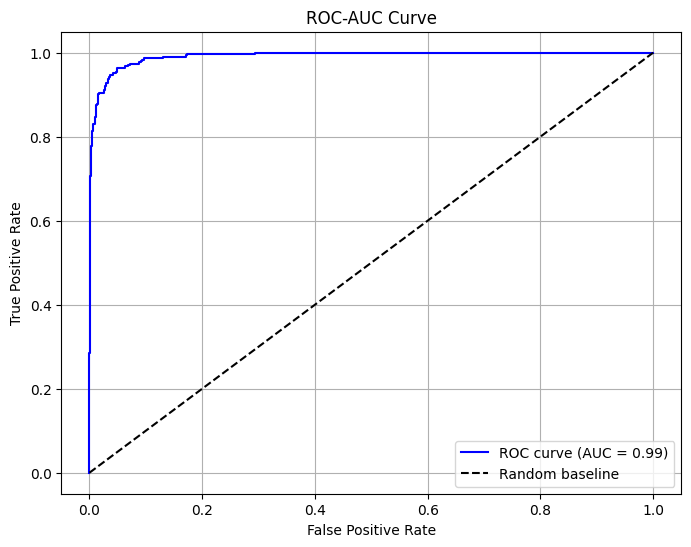

In [33]:
# Predict probabilities
y_pred_probs = model.predict(X_preprocessed2)

# Compute ROC curve and AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [34]:
import tensorflow as tf
import numpy
import PIL
print("TensorFlow version:", tf.__version__)
print("Pillow version:",PIL.__version__)
print("Numpy version",numpy.__version__)

TensorFlow version: 2.18.0
Pillow version: 11.2.1
Numpy version 1.26.4
